Classifying African & Asian Elephants <br>
Dataset: https://www.kaggle.com/datasets/vivmankar/asian-vs-african-elephant-image-classification/data <br>
By: Lie Reubensto

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import cardinality
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
# Load dataset
train_path = "./dataset/train"
val_path = "./dataset/test"

batch_size = 16
img_size = (224, 224) # The dimension for EfficientNetB0

train_dataset = image_dataset_from_directory(train_path, shuffle=False, batch_size=batch_size, image_size=img_size)
val_dataset = image_dataset_from_directory(val_path, shuffle=True, seed=42, batch_size=batch_size, image_size=img_size)

Found 840 files belonging to 2 classes.
Found 188 files belonging to 2 classes.


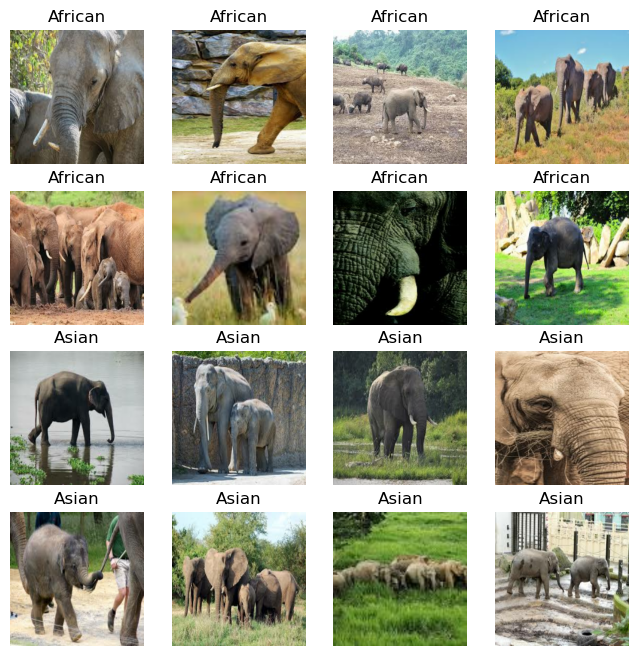

In [3]:
class_names = train_dataset.class_names
num_classes = len(train_dataset.class_names)
images_per_class = 8  # Number of images per class
total_images = num_classes * images_per_class

# Dictionary to store images for each class
images_by_class = {i: [] for i in range(num_classes)}

# Gather 8 images from each class
for image, label in train_dataset:
    label = label.numpy()
    for i in range(len(label)):
        class_idx = label[i]
        if len(images_by_class[class_idx]) < images_per_class:
            images_by_class[class_idx].append(image[i])
    # Stop when we have enough images
    if all(len(images) == images_per_class for images in images_by_class.values()):
        break

# Plot
plt.figure(figsize=(8, 8))
count = 0
for class_idx in images_by_class:
    for img in images_by_class[class_idx]:
        ax = plt.subplot(4, 4, count + 1)
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(class_names[class_idx])
        plt.axis("off")
        count += 1

plt.show()

In [4]:
# Split validation dataset to validation and testing dataset
val_batches = cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 7)
val_dataset = val_dataset.skip(val_batches // 7)
print(f'Val Batches: {cardinality(val_dataset)}')
print(f'Test Batches: {cardinality(test_dataset)}')

Val Batches: 11
Test Batches: 1


In [5]:
# Autotuning dataset
autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=autotune)
val_dataset = val_dataset.prefetch(buffer_size=autotune)
test_dataset = test_dataset.prefetch(buffer_size=autotune)

In [6]:
# Base model from the pre-trained model for RGB images
img_shape = img_size + (3,) # 3 channels of color (RGB)
base_model = EfficientNetB0(input_shape=img_shape, include_top=False, weights="imagenet", pooling="max")

In [7]:
# Feature extraction in transfer learning
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 1280)


In [8]:
# Set base model to not trainable
base_model.trainable = False

In [9]:
# Model for predictions
input = Input(shape=img_shape)
journey = tf.keras.applications.efficientnet.preprocess_input(input)
journey = base_model(journey, training=False)
journey = layers.Dense(1024, activation="relu")(journey)
journey = layers.Dropout(0.2)(journey)
output = layers.Dense(1, activation="sigmoid")(journey)
curr_model = Model(input, output)

In [10]:
# Summary curr_model
curr_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 5362340 (20.46 MB)
Trainable params: 1312769 (5.01 MB)
Non-trainable params: 4049571 (15.45 MB)
_________________

In [11]:
# Trainable variables
len(curr_model.trainable_variables)

4

In [12]:
# Compile curr_model
curr_model.compile(optimizer="sgd", loss="binary_crossentropy", metrics=["accuracy"])

In [13]:
# Initial loss and accuracy
curr_model.evaluate(val_dataset)

11/11 [==============================] - 10s 438ms/step - loss: 1.0223 - accuracy: 0.4651


[1.0222980976104736, 0.4651162922382355]

In [14]:
# Train the curr_model
init_epoch = 15
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=2)
curr_history = curr_model.fit(train_dataset, epochs=init_epoch, validation_data=val_dataset, verbose=2, callbacks=[lr_scheduler])

Epoch 1/15
53/53 - 40s - loss: 0.5961 - accuracy: 0.9702 - val_loss: 3.8551 - val_accuracy: 0.4942 - lr: 0.0100 - 40s/epoch - 755ms/step
Epoch 2/15
53/53 - 30s - loss: 0.3999 - accuracy: 0.9560 - val_loss: 3.7636 - val_accuracy: 0.5000 - lr: 0.0100 - 30s/epoch - 563ms/step
Epoch 3/15
53/53 - 30s - loss: 0.1834 - accuracy: 0.9667 - val_loss: 3.1322 - val_accuracy: 0.4651 - lr: 0.0100 - 30s/epoch - 563ms/step
Epoch 4/15
53/53 - 30s - loss: 0.1493 - accuracy: 0.9571 - val_loss: 2.8624 - val_accuracy: 0.4826 - lr: 0.0100 - 30s/epoch - 563ms/step
Epoch 5/15
53/53 - 24s - loss: 0.1447 - accuracy: 0.9536 - val_loss: 2.7662 - val_accuracy: 0.4651 - lr: 0.0100 - 24s/epoch - 449ms/step
Epoch 6/15
53/53 - 18s - loss: 0.1403 - accuracy: 0.9452 - val_loss: 2.4901 - val_accuracy: 0.4884 - lr: 0.0100 - 18s/epoch - 341ms/step
Epoch 7/15
53/53 - 19s - loss: 0.1348 - accuracy: 0.9452 - val_loss: 2.4625 - val_accuracy: 0.4884 - lr: 0.0100 - 19s/epoch - 362ms/step
Epoch 8/15
53/53 - 18s - loss: 0.1315 - a

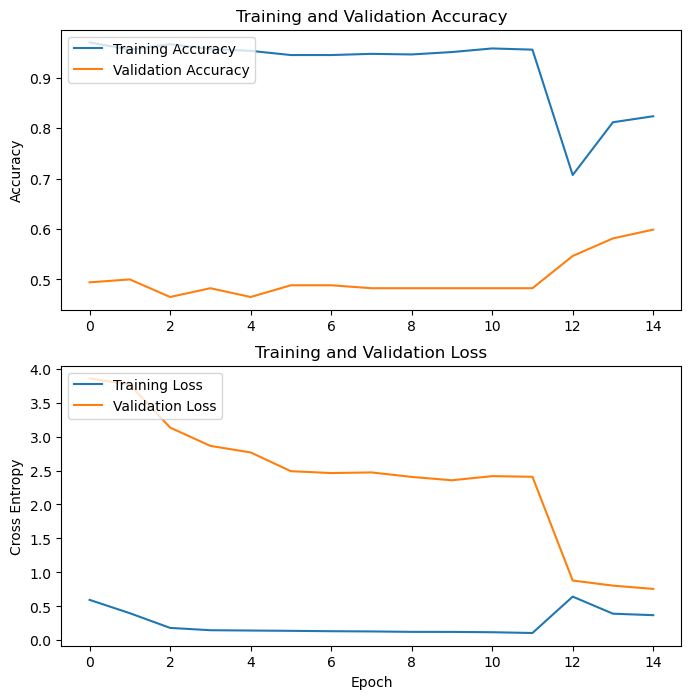

In [15]:
# Training-Validation result of curr_model
acc = curr_history.history['accuracy']
loss = curr_history.history['loss']
val_acc = curr_history.history['val_accuracy']
val_loss = curr_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.title('Training and Validation Accuracy')
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(2, 1, 2)
plt.title('Training and Validation Loss')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend(loc='upper left')

plt.show()

The model is extremely overfitting

In [16]:
# Set base model to trainable
base_model.trainable = True

In [17]:
# curr_model summary
curr_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 5362340 (20.46 MB)
Trainable params: 5320317 (20.30 MB)
Non-trainable params: 42023 (164.16 KB)
_________________

In [18]:
# Fine Tuning the base_model
print(f"Number of layers in base model: {len(base_model.layers)}")

Number of layers in base model: 239


In [19]:
# Freezing the first determined amount of layers
start_ft = len(base_model.layers) - 3
for layer in base_model.layers[:start_ft]:
    # if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = False

In [20]:
# Compile the fine tuning part of curr_model
curr_model.compile(optimizer="sgd", loss="binary_crossentropy", metrics=["accuracy"])

In [21]:
# Trainable variables from the new compiling
len(curr_model.trainable_variables)

6

In [22]:
# Train the fine-tuning curr_model
ft_epoch = 15
total_epoch =  init_epoch + ft_epoch
curr_history_ft = curr_model.fit(train_dataset, epochs=total_epoch, initial_epoch=curr_history.epoch[-1], validation_data=val_dataset, verbose=2, callbacks=[lr_scheduler])

Epoch 15/30
53/53 - 25s - loss: 0.0759 - accuracy: 0.9810 - val_loss: 2.2930 - val_accuracy: 0.4826 - lr: 0.0100 - 25s/epoch - 467ms/step
Epoch 16/30
53/53 - 18s - loss: 0.0973 - accuracy: 0.9655 - val_loss: 2.1457 - val_accuracy: 0.5116 - lr: 0.0100 - 18s/epoch - 347ms/step
Epoch 17/30
53/53 - 19s - loss: 0.0920 - accuracy: 0.9655 - val_loss: 2.3097 - val_accuracy: 0.4826 - lr: 0.0100 - 19s/epoch - 351ms/step
Epoch 18/30

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
53/53 - 19s - loss: 0.0890 - accuracy: 0.9714 - val_loss: 2.3014 - val_accuracy: 0.4942 - lr: 0.0100 - 19s/epoch - 353ms/step
Epoch 19/30
53/53 - 18s - loss: 0.5439 - accuracy: 0.7560 - val_loss: 0.8515 - val_accuracy: 0.5872 - lr: 1.0000e-03 - 18s/epoch - 349ms/step
Epoch 20/30
53/53 - 18s - loss: 0.3417 - accuracy: 0.8500 - val_loss: 0.8352 - val_accuracy: 0.5930 - lr: 1.0000e-03 - 18s/epoch - 348ms/step
Epoch 21/30
53/53 - 18s - loss: 0.3306 - accuracy: 0.8429 - val_loss: 0.8047 - val_acc

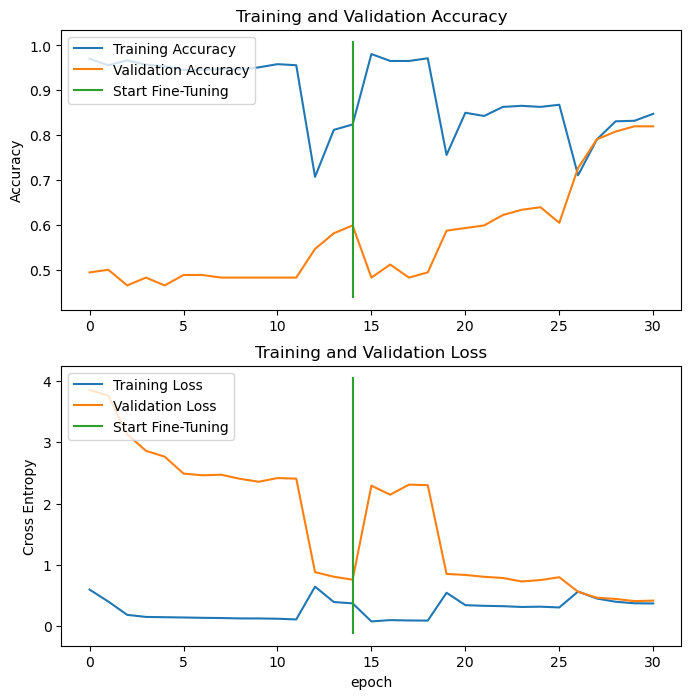

In [23]:
# Comparison of Training-Validation result of curr_model before and after fine-tuning
acc += curr_history_ft.history['accuracy']
loss += curr_history_ft.history['loss']
val_acc += curr_history_ft.history['val_accuracy']
val_loss += curr_history_ft.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.title('Training and Validation Accuracy')
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([init_epoch-1,init_epoch-1], plt.ylim(), label='Start Fine-Tuning')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(2, 1, 2)
plt.title('Training and Validation Loss')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([init_epoch-1,init_epoch-1], plt.ylim(), label='Start Fine-Tuning')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.legend(loc='upper left')

plt.show()

The training of the unfrozen layers of the pre-trained model seems to be able to mitigate the overfitting problem, albeit only partially helping

In [24]:
# Evaluate model
curr_model.evaluate(test_dataset)

1/1 [==============================] - 1s 702ms/step - loss: 0.3220 - accuracy: 0.9375


[0.32199767231941223, 0.9375]

Real Predictions:
 [0.45086852 0.54761016 0.50449103 0.605497   0.98223126 0.1489245
 0.9898367  0.97674453 0.27026868 0.37552705 0.30415943 0.301844
 0.29213107 0.16886558 0.8520303  0.39394647]
Predictions:
 [0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0]
Real:
 [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0]


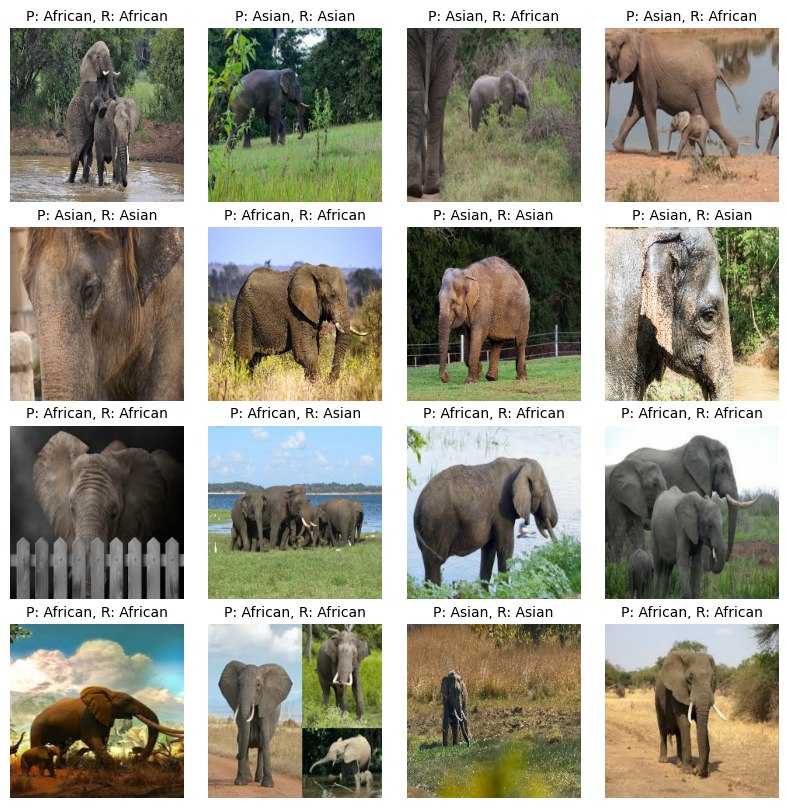

In [25]:
# Retrieve a batch of images from the test dataset
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = curr_model.predict_on_batch(image_batch).flatten()
print('Real Predictions:\n', predictions)

predictions = tf.where(predictions < 0.5, 0, 1)
print('Predictions:\n', predictions.numpy())
print('Real:\n', label_batch)

plt.figure(figsize=(8, 8))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f"P: {class_names[predictions[i]]}, R: {class_names[label_batch[i]]}", fontsize=10)
  plt.axis("off")
plt.tight_layout(pad=0.4)
plt.show()

In [26]:
# Clear Session
tf.keras.backend.clear_session()